In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# Завантажуємо дані
df = pd.read_csv('../data/dataset_for_modeling.csv', index_col='DateTime', parse_dates=True)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

# Створюємо часові ознаки
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['day_of_year'] = df_daily.index.dayofyear

# Розділяємо X та y, тренувальний та тестовий набори
X = df_daily.drop(columns=['Global_active_power'])
y = df_daily['Global_active_power']
X_train, X_test = X.loc[:'2009-12-31'], X.loc['2010-01-01':]
y_train, y_test = y.loc[:'2009-12-31'], y.loc['2010-01-01':]

In [2]:
# Базові моделі (ті ж, що і для Voting)
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Мета-модель (зазвичай проста, наприклад, лінійна регресія)
meta_model = LinearRegression()

# Створюємо та навчаємо StackingRegressor
# cv=5 означає, що для навчання мета-моделі будуть використовуватися 5-кратна крос-валідація
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=5)
print("Починаємо навчання моделі Stacking...")
stacking_model.fit(X_train, y_train)
print("Навчання завершено.")

Починаємо навчання моделі Stacking...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 3
[LightGBM] [Info] Start training from score 315.359572
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 883, number of used features: 3
[LightGBM] [Info] Start training from score 309.669556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] 

Stacking Ensemble MAE: 182.65


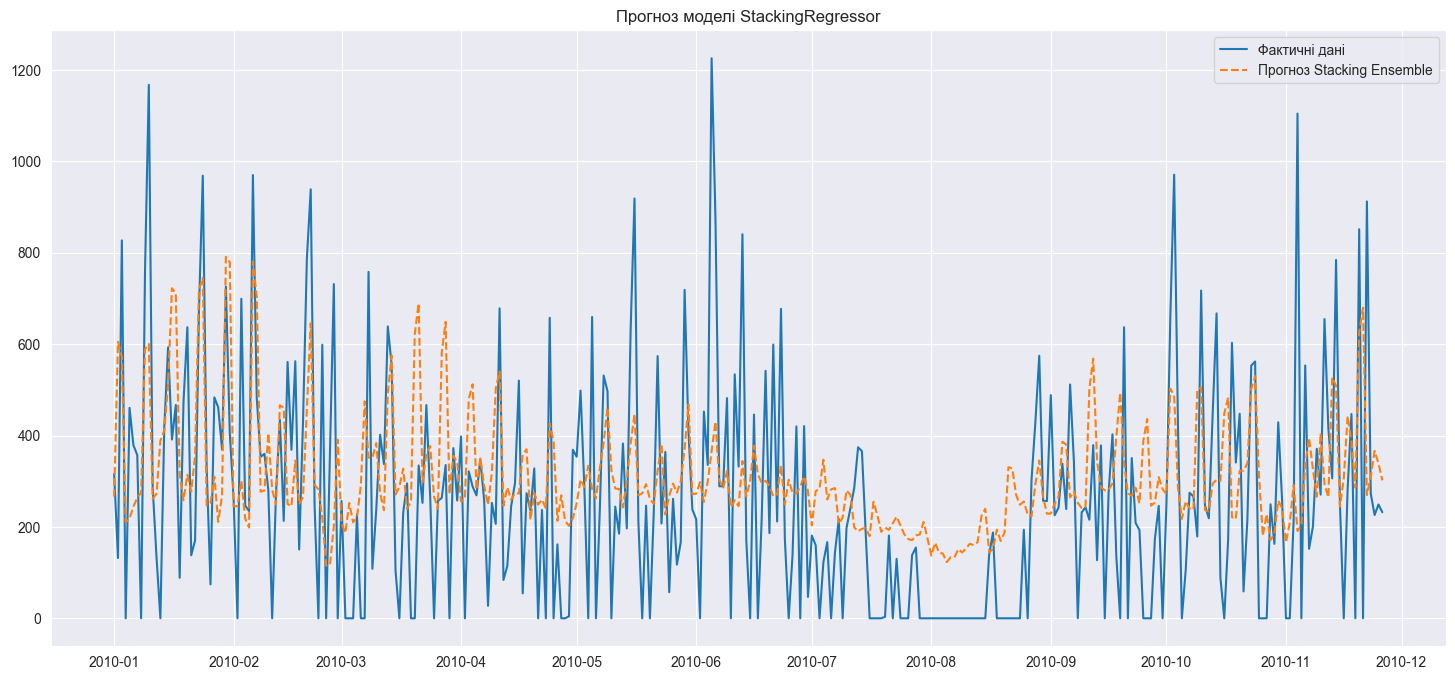

In [3]:
from matplotlib import pyplot as plt

# Робимо прогноз
preds_stacking = stacking_model.predict(X_test)
print(f"Stacking Ensemble MAE: {mean_absolute_error(y_test, preds_stacking):.2f}")

# Для порівняння, MAE з попереднього ноутбука:
# (Вставте сюди ваші значення MAE для RF, LGBM та Voting)
# print(f"RandomForest MAE: ...")
# print(f"LightGBM MAE: ...")
# print(f"Voting Ensemble MAE: ...")

# Візуалізація
plt.figure(figsize=(18, 8))
plt.plot(y_test, label='Фактичні дані')
plt.plot(y_test.index, preds_stacking, label='Прогноз Stacking Ensemble', linestyle='--')
plt.title('Прогноз моделі StackingRegressor')
plt.legend()
plt.show()